In [427]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rcParams
from scipy.integrate import odeint
import lmfit
from lmfit.lineshapes import gaussian, lorentzian   #Installing necessay libraries
from lmfit import report_fit
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
pio.renderers.default = "notebook"
%matplotlib inline
plt.style.use('ggplot')
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')
%matplotlib inline

In [428]:
data=pd.read_excel("C:/Users/hp/Desktop/Ind_death.xlsx") #importing death count data for india
data.head()

,Date,Decease
0,2022-11-02,530461
1,2022-11-01,530452
2,2022-10-31,529077
3,2022-10-30,529024
4,2022-10-29,529016


In [429]:

data = data.sort_values(by='Date') # sorting data of death count to start for 0th day
data

,Date,Decease
1015,2020-01-22,0
1014,2020-01-23,0
1013,2020-01-24,0
1012,2020-01-25,0
1011,2020-01-26,0
...,...,...
4,2022-10-29,529016
3,2022-10-30,529024
2,2022-10-31,529077
1,2022-11-01,530452


Text(0, 0.5, 'Counts in lakhs')

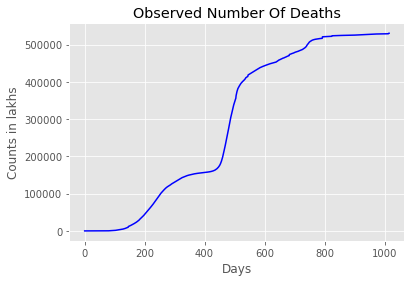

In [430]:
plt.plot(np.arange(0,1016,1),data.loc[:,"Decease"],color="blue")
plt.title('Observed Number Of Deaths')
plt.xlabel('Days')                                              #Plotting death count data
plt.ylabel('Counts in lakhs')

In [431]:

Start_N  = 1380004385
Start_E = 1
Start_I = 1
Start_Q = 0            #defining inital values for S,E,Q,I,R,D,V,H
Start_H = 0
Start_R = 0
Start_D = 0
Start_V = 2


giga= 0.80
tera= 0.15
mega= 0.60
kilo=  0.14
nano=  0.13
gamma = 1/2.9
omega =  0.05
theta = 1/12
delta = 1/5.2         # defining initial guess for parameters
pi = 0.60
alpha = 0.40
sigma = 1/6.5
lamda = 1/7.5
#beta = 1.37
start_R = 3.0
end_R = 0.9
Stch = 2.5
x0 = 130
days = 180
days_fit = 1016
x_data = np.arange(0, days_fit, 1)

In [432]:
def beta(t):
        return Chang_R(t, start_R, Stch, x0, end_R) * gamma            
def Chang_R(t, start_R, Stch, x0, end_R):                                #Defining varying transmission rate and reproducton number with time
        return (start_R - end_R) / (1 + np.exp(-Stch*(-t+x0))) + end_R



In [433]:
def core(n, t, giga, tera, mega, kilo, nano, gamma, theta, delta, pi, alpha, sigma, lamda, omega,start_R, end_R, Stch, x0):

    
    
    def beta(t):
        return Chang_R(t, start_R, Stch, x0, end_R) * gamma
    def Chang_R(t, start_R, Stch, x0, end_R):
        return (start_R - end_R) / (1 + np.exp(-Stch*(-t+x0))) + end_R

    
    S, E, Q, I, C, R, D, V, T = n
    N = S + E + Q + I + C + R + D + V
    Chan_S = -beta(t)*I*(S/N) - omega*(S-(beta(t)*I))*(1-(S/N)) 
    Chan_E =  beta(t)*I*(S/N) - delta*giga*E - tera*(1-giga)*E
    Chan_Q =  tera*(1-giga)*E - nano*mega*Q - kilo*(1 - mega)*Q
    Chan_I =  delta*giga*E - gamma*(1-pi)*I - theta*pi*I + nano*mega*Q  #Core mathematical model
    Chan_H = theta*pi*I - sigma*(1-alpha)*C - lamda*alpha*C
    Chan_R = gamma*(1-pi)*I + sigma*(1-alpha)*C + kilo*(1 - mega)*Q
    Chan_D = lamda*alpha*C
    Chan_V = omega*(S-(beta(t)*I))*(1-(S/N))   
    Tot    = Chan_S + Chan_E + Chan_Q + Chan_I + Chan_H + Chan_R + Chan_D + Chan_V
    
    
   
    return [Chan_S, Chan_E,  Chan_Q, Chan_I, Chan_H , Chan_R , Chan_D , Chan_V, Tot]

In [434]:
def gate(t, start_val, params):
    Start_E, Start_Q, Start_I, Start_H, Start_R, Start_D, Start_V, Start_N = start_val
    giga, tera, mega, kilo, nano, gamma, theta, delta, pi, alpha, sigma, lamda, omega, start_R, end_R, Stch, x0 = params
    Start_S = Start_N - (Start_E + Start_Q + Start_I + Start_H + Start_R + Start_D + Start_V)
    outc = odeint(core, [Start_S, Start_E, Start_Q, Start_I, Start_H, Start_R, Start_D, Start_V, Start_N], t, args=(giga, tera, mega, kilo, nano, gamma, theta, delta, pi, alpha, sigma, lamda, omega, start_R, end_R, Stch, x0))
    return outc

In [435]:
def prime(Start_E, Start_Q, Start_I, Start_H, Start_R, Start_D, Start_V, Start_N, giga, tera, mega, kilo, nano, gamma, theta, delta, pi, alpha, sigma, lamda, omega, start_R, end_R, Stch, x0, days):
    start_val = [Start_E, Start_Q, Start_I, Start_H, Start_R, Start_D, Start_V, Start_N]
    params = [giga, tera, mega, kilo, nano, gamma, theta, delta, pi, alpha, sigma, lamda, omega, start_R, end_R, Stch, x0]
    period = np.arange(0, days, 1)
    fin = gate(period, start_val, params)
    S, E, Q, I, C, R, D, V, T= fin[:, 0], fin[:, 1], fin[:, 2], fin[:, 3], fin[:, 4], fin[:, 5], fin[:, 6], fin[:, 7], fin[:, 8]
    R0_over_time = Chang_R(period, start_R, Stch, x0, end_R)
    
    
    plt.plot(np.arange(0,days,1),R0_over_time,color="blue")
    plt.title("R0 varying over time")
    plt.xlabel("Days")                                     #Plotting varying reproduction number with time
    plt.ylabel("R0_value")
    
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=period, y=S, 
                             mode='lines', 
                             name='Susceptible_Count'))
    fig.add_trace(go.Scatter(x=period, y=E, 
                             mode='lines', 
                             name='Exposed_Count'))
    fig.add_trace(go.Scatter(x=period, y=Q, 
                             mode='lines', 
                             name='Quarantine_Count'))
    fig.add_trace(go.Scatter(x=period, y=I, 
                             mode='lines', 
                             name='Infected_Count'))      # Plotting the computed compartment counts
    fig.add_trace(go.Scatter(x=period, y=C, 
                             mode='lines', 
                             name='Hospitalization_Count'))
    fig.add_trace(go.Scatter(x=period, y=R, 
                             mode='lines',
                             name='Recovered_Count'))
    fig.add_trace(go.Scatter(x=period, y=D, 
                             mode='lines',
                             name='Death_Count'))
    fig.add_trace(go.Scatter(x=period, y=V, 
                             mode='lines',
                             name='Vaccinated_Count'))
    fig.add_trace(go.Scatter(x=period, y=T, 
                             mode='lines',
                             name='Total_Count'))
    
    
    

    if days <= 30:
        step = 1
    elif days <= 180:   #assigning range of values to step for better visualization
        step = 30
    else:
        step = 100
    
 
        
    
    
    
    fig.update_layout(title='Simulation of SEQIHRDV Model',xaxis_title='Days',yaxis_title='Compartment_Count',title_x=0.5,width=900, height=600,plot_bgcolor='black')
                 # defining layout dimensions for computed compartment counts visualization
    
    fig.update_xaxes(tickangle=-90, tickformat = None, tickmode='array', tickvals=np.arange(0, days + 1, step))
                #varying tick values according to defined steps for better visualization
    fig.show()
    
    
    
interact(prime, 
         Start_E=IntSlider(min=0, max=100000, step=1, value=Start_E, description='Start_E', style=style, layout=slider_layout),
         Start_Q=IntSlider(min=0, max=100000, step=1, value=Start_Q, description='Start_Q', style=style, layout=slider_layout),
         Start_I=IntSlider(min=0, max=100000, step=10, value=Start_I, description='Start_I', style=style, layout=slider_layout),
         Start_H=IntSlider(min=0, max=100000, step=1, value=Start_H, description='Start_H', style=style, layout=slider_layout),
         Start_R=IntSlider(min=0, max=100000, step=10, value=Start_R, description='Start_R', style=style, layout=slider_layout),
         Start_D=IntSlider(min=0, max=100000, step=10, value=Start_D, description='Start_D', style=style, layout=slider_layout),
         Start_V=IntSlider(min=0, max=100000, step=10, value=Start_V, description='Start_V', style=style, layout=slider_layout),
         Start_N=IntSlider(min=0, max=1380000000, step=1000, value=Start_N, description='Start_N', style=style, layout=slider_layout),
         giga=FloatSlider(min=0, max=1, step=0.01, value=giga, description='Fraction E to I', style=style, layout=slider_layout),
         tera=FloatSlider(min=0, max=10, step=0.01, value=tera, description='E to Q rate', style=style, layout=slider_layout),
         mega=FloatSlider(min=0, max=1, step=0.01, value=mega, description='Fraction Q to I', style=style, layout=slider_layout),
         kilo=FloatSlider(min=0, max=10, step=0.01, value=kilo, description='Q to R rate', style=style, layout=slider_layout),
         nano=FloatSlider(min=0, max=10, step=0.01, value=nano, description='Q to I rate', style=style, layout=slider_layout),
         gamma=FloatSlider(min=0, max=10, step=0.01, value=gamma, description='Recovery rate', style=style, layout=slider_layout),
         theta=FloatSlider(min=0, max=10, step=0.01, value=theta, description='I to C rate', style=style, layout=slider_layout),
         delta=FloatSlider(min=0, max=10, step=0.01, value=delta, description='Incubation rate', style=style, layout=slider_layout),
         pi=FloatSlider(min=0, max=1, step=0.01, value=pi, description='Fraction I to C', style=style, layout=slider_layout),
         alpha=FloatSlider(min=0, max=1, step=0.01, value=alpha, description='Fraction C to D', style=style, layout=slider_layout),
         sigma=FloatSlider(min=0, max=10, step=0.01, value=sigma, description='C to R rate', style=style, layout=slider_layout),
         lamda=FloatSlider(min=0, max=10, step=0.01, value=lamda, description='C to D rate', style=style, layout=slider_layout),
         omega=FloatSlider(min=0, max=10, step=0.01, value=omega, description='omega', style=style, layout=slider_layout),
         start_R=FloatSlider(min=0, max=10, step=0.01, value=start_R, description='Start_Val', style=style, layout=slider_layout),
         end_R=FloatSlider(min=0, max=4, step=0.01, value=end_R, description='End_val', style=style, layout=slider_layout),
         Stch=FloatSlider(min=0, max=20, step=0.01, value=Stch , description='Stretch', style=style, layout=slider_layout),
         x0=FloatSlider(min=0, max=180, step=1, value=x0, description='D-Day', style=style, layout=slider_layout),
         days=IntSlider(min=1, max=600, step=7, value=days, description='Days', style=style, layout=slider_layout),
         #action=ToggleButton(value=False, description='interac', disabled=False, button_style='', \
             #tooltip='Click to enable interactivity', icon='check-circle')
        );

interactive(children=(IntSlider(value=1, description='Start_E', layout=Layout(width='99%'), max=100000, style=…

In [436]:
def fitter(x,giga,tera,mega,kilo,nano,pi,alpha,start_R,end_R,Stch,x0,omega):
    start_val = [Start_E, Start_Q, Start_I, Start_H, Start_R, Start_D, Start_V, Start_N]
    params = [giga, tera, mega, kilo, nano, gamma, theta, delta, pi, alpha, sigma, lamda, omega,start_R, end_R, Stch, x0]
    period = np.arange(0, days_fit, 1)                               # defining function to provide model output to LM fit model
    ret=gate(period, start_val, params)
    return ret[:, 6]


In [437]:
mod = lmfit.Model(fitter)
mod.set_param_hint("giga", value=0.40,min=0.05, max=1.0 ,vary=True)
mod.set_param_hint("tera", value=0.11, vary=True)
mod.set_param_hint("mega", value=0.20, vary=True)
mod.set_param_hint("kilo", value=0.12, vary=True)
mod.set_param_hint("nano", value=0.11, vary=True)
mod.set_param_hint("pi", value=0.60, vary=True)                # defining LM fit  model with parameter range
mod.set_param_hint("alpha", value=0.40, vary=True)
mod.set_param_hint("start_R", value=3.0,min=2.0, max=5.0, vary=True)
mod.set_param_hint("end_R", value=0.9,min=0.3, max=3.5, vary=True)
mod.set_param_hint("Stch", value=2.5,min=0.01, max=5.0, vary=True)
mod.set_param_hint("x0", value=80,min=0, max=120, vary=True)
mod.set_param_hint("omega", value=0.05, vary=True)
params = mod.make_params()
fit_method = "leastsq"

In [438]:
result = mod.fit(data.loc[:,"Decease"], params, method="least_squares", x=x_data) 
                # Fitting data and model output 
result.best_values
                # Displaying optimized parameters

C:\Users\hp\AppData\Local\Temp/ipykernel_17120/2955861214.py:8: RuntimeWarning:

overflow encountered in exp

C:\Users\hp\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



{'giga': 0.39516796959207756,
 'tera': 0.09446150292086693,
 'mega': 0.14679650125326807,
 'kilo': 0.09804183519578794,
 'nano': 0.10964426949440642,
 'pi': 0.5842870885765072,
 'alpha': 0.38714007448561283,
 'start_R': 2.988313396095232,
 'end_R': 0.918072790218488,
 'Stch': 2.500714012589111,
 'x0': 79.97186846703079,
 'omega': 0.010109528588129519}

C:\Users\hp\AppData\Local\Temp/ipykernel_17120/2955861214.py:8: RuntimeWarning:

overflow encountered in exp



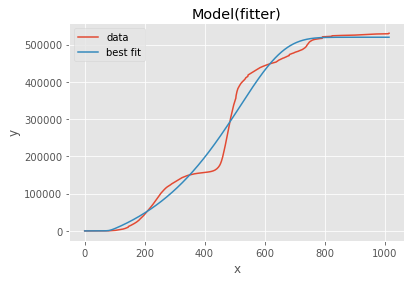

In [439]:
result.plot_fit(datafmt="-");
                   # Plotting the curve fits

In [440]:
report_fit(result)
          # displaying detailed fit statistics

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 39
    # data points      = 1016
    # variables        = 12
    chi-square         = 6.3053e+11
    reduced chi-square = 6.2801e+08
    Akaike info crit   = 20594.1314
    Bayesian info crit = 20653.2149
[[Variables]]
    giga:     0.39516797 +/- 0.03503879 (8.87%) (init = 0.4)
    tera:     0.09446150 +/- 7.37947959 (7812.16%) (init = 0.11)
    mega:     0.14679650 +/- 103.501099 (70506.52%) (init = 0.2)
    kilo:     0.09804184 +/- 7.34636702 (7493.09%) (init = 0.12)
    nano:     0.10964427 +/- 130.052123 (118612.79%) (init = 0.11)
    pi:       0.58428709 +/- 93.5547723 (16011.78%) (init = 0.6)
    alpha:    0.38714007 +/- 107.492685 (27765.84%) (init = 0.4)
    start_R:  2.98831340 +/- 131.314254 (4394.26%) (init = 3)
    end_R:    0.91807279 +/- 104.652798 (11399.18%) (init = 0.9)
    Stch:     2.50071401 +/- 10549.1148 (421844.11%) (init = 2.5)
    x0:       79.9718685 +/- 819.149912 (1024.30%) (

In [442]:
 
         # Simulating the model output with feeding the optimized parameters

interact(prime, 
         Start_E=IntSlider(min=0, max=100000, step=1, value=Start_E, description='Start_E', style=style, layout=slider_layout),
         Start_Q=IntSlider(min=0, max=100000, step=1, value=Start_Q, description='Start_Q', style=style, layout=slider_layout),
         Start_I=IntSlider(min=0, max=100000, step=10, value=Start_I, description='Start_I', style=style, layout=slider_layout),
         Start_H=IntSlider(min=0, max=100000, step=1, value=Start_H, description='Start_H', style=style, layout=slider_layout),
         Start_R=IntSlider(min=0, max=100000, step=10, value=Start_R, description='Start_R', style=style, layout=slider_layout),
         Start_D=IntSlider(min=0, max=100000, step=10, value=Start_D, description='Start_D', style=style, layout=slider_layout),
         Start_V=IntSlider(min=0, max=100000, step=10, value=Start_V, description='Start_V', style=style, layout=slider_layout),
         Start_N=IntSlider(min=0, max=1380000000, step=1000, value=Start_N, description='Start_N', style=style, layout=slider_layout),
         giga=FloatSlider(min=0, max=1, step=0.01, value=result.best_values['giga'], description='Fraction E to I', style=style, layout=slider_layout),
         tera=FloatSlider(min=0, max=10, step=0.01, value=result.best_values['tera'], description='E to Q rate', style=style, layout=slider_layout),
         mega=FloatSlider(min=0, max=1, step=0.01, value=result.best_values['mega'], description='Fraction Q to I', style=style, layout=slider_layout),
         kilo=FloatSlider(min=0, max=10, step=0.01, value=result.best_values['kilo'], description='Q to R rate', style=style, layout=slider_layout),
         nano=FloatSlider(min=0, max=10, step=0.01, value=result.best_values['nano'], description='Q to I rate', style=style, layout=slider_layout),
         gamma=FloatSlider(min=0, max=10, step=0.01, value=gamma, description='Recovery rate', style=style, layout=slider_layout),
         theta=FloatSlider(min=0, max=10, step=0.01, value=theta, description='I to C rate', style=style, layout=slider_layout),
         delta=FloatSlider(min=0, max=10, step=0.01, value=delta, description='Incubation rate', style=style, layout=slider_layout),
         pi=FloatSlider(min=0, max=1, step=0.01, value=result.best_values['pi'], description='Fraction I to C', style=style, layout=slider_layout),
         alpha=FloatSlider(min=0, max=1, step=0.01, value=result.best_values['alpha'], description='Fraction C to D', style=style, layout=slider_layout),
         sigma=FloatSlider(min=0, max=10, step=0.01, value=sigma, description='C to R rate', style=style, layout=slider_layout),
         lamda=FloatSlider(min=0, max=10, step=0.01, value=lamda, description='C to D rate', style=style, layout=slider_layout),
         omega=FloatSlider(min=0, max=10, step=0.01, value=result.best_values['omega'], description='omega', style=style, layout=slider_layout),
         start_R=FloatSlider(min=0, max=10, step=0.01, value=result.best_values['start_R'], description='Start_Val', style=style, layout=slider_layout),
         end_R=FloatSlider(min=0, max=4, step=0.01, value=result.best_values['end_R'], description='End_val', style=style, layout=slider_layout),
         Stch=FloatSlider(min=0, max=20, step=0.01, value=result.best_values['Stch'] , description='Stretch', style=style, layout=slider_layout),
         x0=FloatSlider(min=0, max=180, step=1, value=result.best_values['x0'], description='D-Day', style=style, layout=slider_layout),
         days=IntSlider(min=1, max=3000, step=7, value=1500, description='Days', style=style, layout=slider_layout),
         #action=ToggleButton(value=False, description='interac', disabled=False, button_style='', \
             #tooltip='Click to enable interactivity', icon='check-circle')
        );





interactive(children=(IntSlider(value=1, description='Start_E', layout=Layout(width='99%'), max=100000, style=…

Code References:

1.https://github.com/silpara/simulators/blob/master/compartmental_models/SEIRD%20Simulator%20with%20Parameter%20Estimation%20in%20Python.ipynb

2.https://github.com/henrifroese/infectious_disease_modelling/blob/master/part_three.ipynb